## Preprocessing Suara Buka Tutup

In [88]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# Definisi variabel global yang hilang
TARGET_SR = 22050  # Sample rate target, umum digunakan 22050 Hz
MAX_LEN = 44100    # Durasi target (misal: 2 detik * 22050 Hz = 44100 sampel)
TRAIN_DIR = 'dataset/train' # Direktori data training, diasumsikan sama dengan TARGET_DIR
VAL_DIR = 'dataset/val'   # Direktori data validasi, diasumsikan sama dengan TARGET_DIR

In [89]:
import pandas as pd # Pastikan pandas diimpor

# Menghapus baris dengan data NaN atau invalid
if 'audio_stats' in globals() and isinstance(audio_stats, pd.DataFrame):
    audio_stats_clean = audio_stats.dropna(subset=['file_path', 'label', 'duration'])
    print("DataFrame 'audio_stats_clean' berhasil dibuat.")
else:
    print("Error: DataFrame 'audio_stats' tidak ditemukan atau bukan DataFrame.")
    print("Harap pastikan sel yang membuat 'audio_stats' (yaitu, sel `semearUnerzY`) telah dijalankan terlebih dahulu.")
    audio_stats_clean = pd.DataFrame() # Inisialisasi DataFrame kosong untuk menghindari error lebih lanjut jika tidak ada data

In [59]:
def preprocess_audio(file_path, target_sr=TARGET_SR, target_len=MAX_LEN, noise_reduction=True):
    """
    Membaca audio dan mengubah ke bentuk konsisten (sample rate, durasi, normalisasi)
    """
    # 1. Load audio
    y, sr = librosa.load(file_path, sr=target_sr)

    # 2. Trim ke durasi tetap (potong / pad)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode='constant')
    else:
        y = y[:target_len]

    # 3. Normalisasi amplitudo (skala -1 sampai 1)
    y = y / np.max(np.abs(y) + 1e-6)

    # 4. Hilangkan noise kecil
    if noise_reduction:
        y[np.abs(y) < 0.005] = 0.0

    return y, sr

Menggunakan contoh file: dataset/train/buka/buka_020.wav
Sample rate asli: 48000 Hz | Durasi asli: 2.98s
Sample rate baru: 22050 Hz | Durasi baru: 2.00s


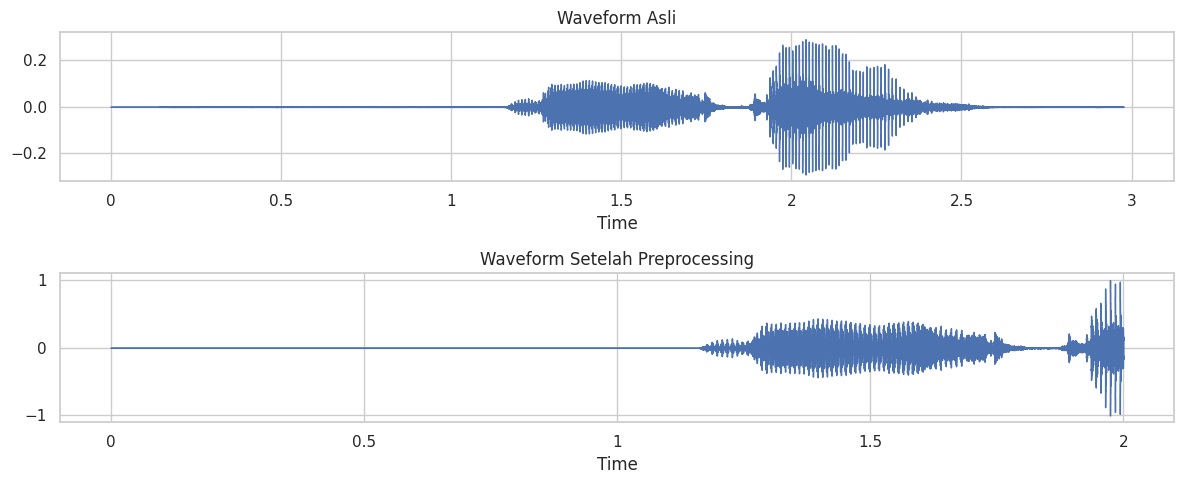

🔊 Sebelum preprocessing:


🔊 Setelah preprocessing:


In [84]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# Pastikan TRAIN_DIR terdefinisi (seharusnya sudah di sel sebelumnya)
# Pastikan preprocess_audio terdefinisi (seharusnya sudah di sel sebelumnya)

# Memilih sample file secara lebih robust
buka_dir = os.path.join(TRAIN_DIR, "buka")
if os.path.exists(buka_dir) and os.path.isdir(buka_dir):
    buka_files = [f for f in os.listdir(buka_dir) if f.lower().endswith('.wav')]
    if buka_files:
        # Coba ambil file ke-10 (indeks 9), jika tidak ada, ambil yang pertama
        if len(buka_files) > 9:
            sample_file = os.path.join(buka_dir, buka_files[9]) # Menggunakan indeks 9 untuk file ke-10
        else:
            sample_file = os.path.join(buka_dir, buka_files[0]) # Ambil file pertama jika kurang dari 10
        print(f"Menggunakan contoh file: {sample_file}")
    else:
        print(f"Tidak ada file .wav di {buka_dir}. Tidak dapat melanjutkan perbandingan preprocessing.")
        sample_file = None
else:
    print(f"Direktori {buka_dir} tidak ditemukan. Tidak dapat melanjutkan perbandingan preprocessing.")
    sample_file = None

if sample_file:
    y_raw, sr_raw = librosa.load(sample_file, sr=None)
    y_proc, sr_proc = preprocess_audio(sample_file)

    print(f"Sample rate asli: {sr_raw} Hz | Durasi asli: {len(y_raw)/sr_raw:.2f}s")
    print(f"Sample rate baru: {sr_proc} Hz | Durasi baru: {len(y_proc)/sr_proc:.2f}s")

    fig, ax = plt.subplots(2, 1, figsize=(12, 5))
    librosa.display.waveshow(y_raw, sr=sr_raw, ax=ax[0])
    ax[0].set_title("Waveform Asli")
    librosa.display.waveshow(y_proc, sr=sr_proc, ax=ax[1])
    ax[1].set_title("Waveform Setelah Preprocessing")
    plt.tight_layout()
    plt.show()

    print("🔊 Sebelum preprocessing:")
    ipd.display(ipd.Audio(y_raw, rate=sr_raw))
    print("🔊 Setelah preprocessing:")
    ipd.display(ipd.Audio(y_proc, rate=sr_proc))
else:
    print("Tidak dapat melakukan perbandingan preprocessing karena tidak ada sample file yang valid.")

### Preprocessing data audio


In [61]:
import tqdm

def preprocess_dataset(base_path):
    """
    Membaca seluruh file audio dalam folder dan melakukan preprocessing.
    Menghasilkan list (waveform, label)
    """
    data = []
    for label in os.listdir(base_path):
        folder = os.path.join(base_path, label)
        if not os.path.isdir(folder):
            continue
        for fn in tqdm.tqdm(os.listdir(folder), desc=f"Processing {label}"):
            file_path = os.path.join(folder, fn)
            y, sr = preprocess_audio(file_path)
            data.append((y, label))
    return data

import joblib

train_data = preprocess_dataset(TRAIN_DIR)
val_data   = preprocess_dataset(VAL_DIR)

joblib.dump(train_data, "train_preprocessed.pkl")
joblib.dump(val_data, "val_preprocessed.pkl")

print(f"✅ Total data train: {len(train_data)}, val: {len(val_data)}")

Processing tutup: 100%|██████████| 40/40 [00:00<00:00, 336.90it/s]


✅ Total data train: 320, val: 80


### Visualisasi distribusi amplitudo setelah dilakukan Preprocessing

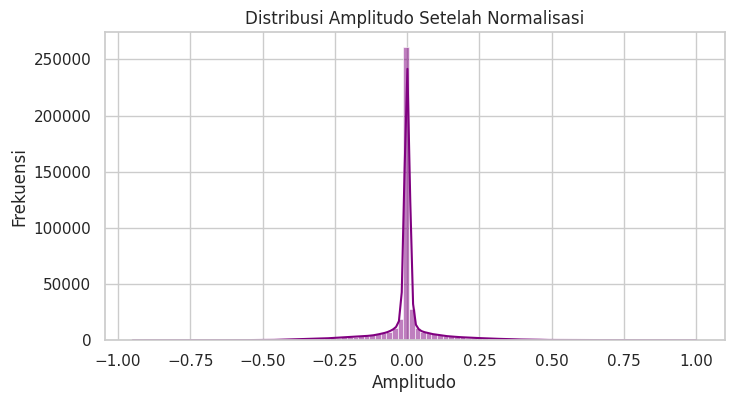

In [62]:
import seaborn as sns

samples = [y for y, _ in train_data[:10]]
amps = np.concatenate(samples)

plt.figure(figsize=(8,4))
sns.histplot(amps, bins=100, color='purple', kde=True)
plt.title("Distribusi Amplitudo Setelah Normalisasi")
plt.xlabel("Amplitudo")
plt.ylabel("Frekuensi")
plt.show()

### Menyimpan dan Memuat data train dan val yang telah dilakukan Preprocessing menjadi .pkl

In [64]:
import numpy as np
import pandas as pd
import librosa
import scipy.stats
import joblib
import tqdm

train_data = joblib.load("train_preprocessed.pkl")
val_data   = joblib.load("val_preprocessed.pkl")

print(f"✅ Data berhasil dimuat. Total train: {len(train_data)}, val: {len(val_data)}")

✅ Data berhasil dimuat. Total train: 320, val: 80


### mengambil berbagai fitur statistik dari sinyal audio (time-series)

In [68]:
def extract_features(y, sr=22050):
    """
    Mengambil fitur statistik dari sinyal audio 1D (time-series)
    """
    feats = {}
    # Fitur domain waktu
    feats['mean'] = np.mean(y)
    feats['var'] = np.var(y)
    feats['skew'] = scipy.stats.skew(y)
    feats['kurt'] = scipy.stats.kurtosis(y)
    feats['rms'] = librosa.feature.rms(y=y).mean() # Diperbarui untuk konsistensi dengan librosa
    feats['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))

    # Fitur domain frekuensi
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    feats['centroid'] = np.mean(centroid)
    feats['bandwidth'] = np.mean(bandwidth)

    # spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    feats['rolloff'] = np.mean(rolloff)

    # Entropy amplitudo (dari distribusi histogram amplitudo)
    # Mengganti nama untuk klarifikasi
    hist, _ = np.histogram(y, bins=50, density=True)
    hist = hist[hist > 0]
    feats['amplitude_entropy'] = -np.sum(hist * np.log2(hist))

    # Menambahkan MFCCs (Mel-frequency cepstral coefficients)
    # Ini adalah fitur yang sangat umum dan kuat dalam pemrosesan audio
    n_mfcc = 13 # Jumlah koefisien MFCC yang umum, konsisten dengan yang digunakan sebelumnya
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Rata-rata setiap koefisien MFCC sepanjang waktu
    for i in range(n_mfcc):
        feats[f'mfcc_mean_{i+1}'] = np.mean(mfccs[i])

    return feats

In [80]:
def build_feature_dataset(preprocessed_data, sr=22050):
    """
    Mengubah list (waveform, label) menjadi DataFrame fitur statistik
    """
    feature_list = []
    for y, label in tqdm.tqdm(preprocessed_data):
        f = extract_features(y, sr)
        f['label'] = label
        feature_list.append(f)
    return pd.DataFrame(feature_list)

train_features = build_feature_dataset(train_data)
val_features   = build_feature_dataset(val_data)

print("✅ Contoh hasil ekstraksi fitur:")
display(train_features.head())

100%|██████████| 80/80 [00:02<00:00, 34.13it/s]

✅ Contoh hasil ekstraksi fitur:


,mean,var,skew,kurt,rms,zcr,centroid,bandwidth,rolloff,amplitude_entropy,...,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_mean_13,label
0,-0.000009,0.023681,0.495464,3.411855,0.098410,0.025015,1074.775108,1403.907915,2124.485621,-54.477681,...,-3.552955,-0.708721,0.597254,-2.526324,-5.450669,3.252294,-9.881175,-0.689911,-2.631492,buka
1,-0.000040,0.015997,0.771071,9.375773,0.076620,0.029286,944.891118,1396.702671,1725.873855,-64.367149,...,-3.383219,1.001530,-0.302338,2.887549,-5.896264,4.941112,-11.356211,3.153998,-2.919726,buka
2,-0.000046,0.011518,0.607628,8.674345,0.063585,0.076183,1832.344623,1843.567399,3858.898505,-75.282432,...,-1.734062,-0.296936,-2.159705,-0.902677,-4.310112,-0.955573,-5.058569,0.004803,-2.895586,buka
3,-0.000029,0.016042,0.771244,9.375992,0.076710,0.029263,939.249863,1392.717316,1703.350620,-64.181933,...,-3.241769,1.048614,-0.050970,2.925751,-5.993064,4.955007,-11.551836,3.049327,-2.936480,buka
4,-0.000025,0.005815,2.535320,39.303658,0.031007,0.012650,529.379122,638.619436,1020.723330,-109.778309,...,-6.196371,-0.610554,0.079576,-1.960696,-3.722306,-1.117094,-3.058955,1.307242,-1.774904,buka


In [81]:
train_features.to_csv("train_features.csv", index=False)
val_features.to_csv("val_features.csv", index=False)
print("File fitur disimpan: train_features.csv dan val_features.csv")

File fitur disimpan: train_features.csv dan val_features.csv


### Seleksi Fitur (SelectKBest dengan f_classif dan RandomForestClassifier)

✅ train_features.csv dan val_features.csv berhasil dimuat.

--- Seleksi Fitur dengan SelectKBest (f_classif) ---
Top 15 fitur berdasarkan f_classif score:



,Feature,Score_f_classif,P_value
18,mfcc_mean_9,244.992418,2.428416e-41
19,mfcc_mean_10,140.576012,4.223061e-27
21,mfcc_mean_12,92.949578,1.828791e-19
15,mfcc_mean_6,48.836221,1.639271e-11
20,mfcc_mean_11,48.771518,1.686826e-11
13,mfcc_mean_4,44.485960,1.135841e-10
16,mfcc_mean_7,36.429460,4.405146e-09
11,mfcc_mean_2,27.442750,2.950938e-07
2,skew,22.215808,3.649611e-06
17,mfcc_mean_8,19.097423,1.683997e-05



Fitur yang terpilih oleh SelectKBest: ['var', 'skew', 'bandwidth', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13']

Shape X_train_selected_kbest: (320, 15)
Shape X_val_selected_kbest: (80, 15)

--- Pentingnya Fitur dengan RandomForestClassifier ---
Top 15 fitur berdasarkan Feature Importance (RandomForestClassifier):



,Feature,Importance
18,mfcc_mean_9,0.225736
19,mfcc_mean_10,0.128663
21,mfcc_mean_12,0.091236
16,mfcc_mean_7,0.064206
20,mfcc_mean_11,0.055674
11,mfcc_mean_2,0.049067
15,mfcc_mean_6,0.043097
17,mfcc_mean_8,0.041986
13,mfcc_mean_4,0.040686
2,skew,0.039016


/tmp/ipython-input-308456287.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(k), palette='viridis')


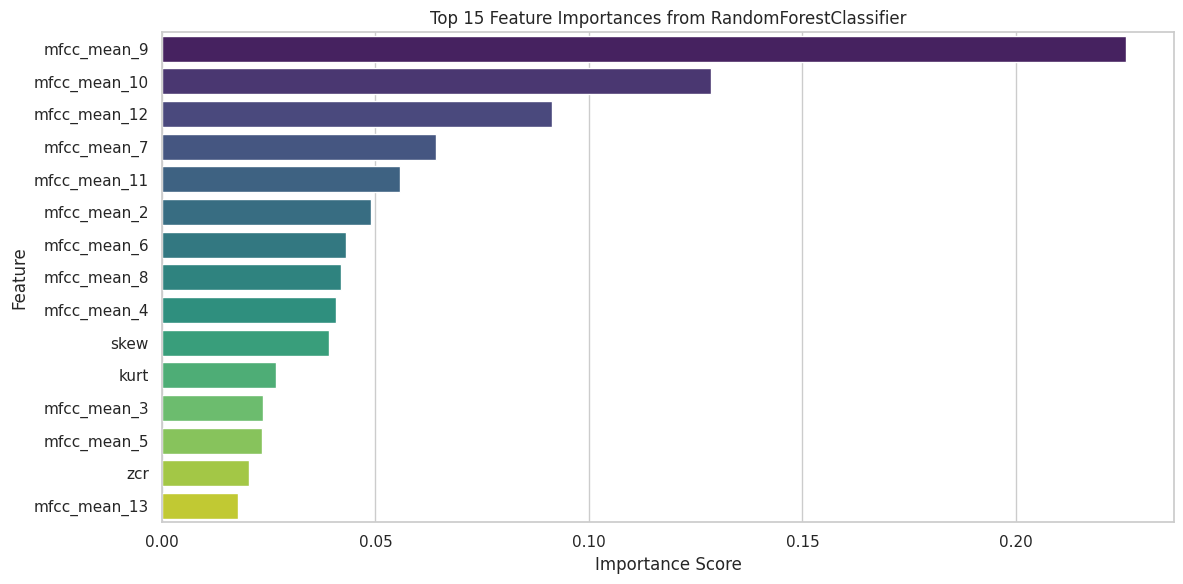

In [82]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Muat data fitur yang sudah diekstrak
# Pastikan Anda sudah menjalankan sel build_feature_dataset sebelumnya untuk mendapatkan train_features dan val_features
try:
    train_features = pd.read_csv("train_features.csv")
    val_features   = pd.read_csv("val_features.csv")
    print("✅ train_features.csv dan val_features.csv berhasil dimuat.")
except FileNotFoundError:
    print("⚠️ File train_features.csv atau val_features.csv tidak ditemukan.")
    print("Harap jalankan kembali sel 'build_feature_dataset' untuk membuat file ini.")
    # Membuat DataFrame dummy agar kode selanjutnya tidak error
    train_features = pd.DataFrame(columns=[f'mfcc_mean_{i+1}' for i in range(13)] + ['label'])
    val_features = pd.DataFrame(columns=[f'mfcc_mean_{i+1}' for i in range(13)] + ['label'])

if train_features.empty or val_features.empty:
    print("DataFrame fitur kosong, tidak dapat melakukan seleksi fitur.")
else:
    # Pisahkan fitur (X) dan target (y)
    X_train = train_features.drop('label', axis=1)
    y_train = train_features['label']
    X_val = val_features.drop('label', axis=1)
    y_val = val_features['label']

    # --- Metode 1: SelectKBest dengan f_classif (Filter Method) ---
    print("\n--- Seleksi Fitur dengan SelectKBest (f_classif) ---")
    # Pilih K fitur terbaik, misalnya 15 fitur
    k = min(15, X_train.shape[1]) # Pastikan k tidak melebihi jumlah fitur yang tersedia
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_train, y_train)

    # Dapatkan skor fitur
    feature_scores = pd.DataFrame({
        'Feature': X_train.columns,
        'Score_f_classif': selector.scores_,
        'P_value': selector.pvalues_
    })
    feature_scores = feature_scores.sort_values(by='Score_f_classif', ascending=False)

    print("Top {} fitur berdasarkan f_classif score:\n".format(k))
    display(feature_scores)

    # Dapatkan nama fitur yang terpilih
    selected_features_kbest = X_train.columns[selector.get_support(indices=True)].tolist()
    print(f"\nFitur yang terpilih oleh SelectKBest: {selected_features_kbest}")

    # Buat DataFrame baru dengan fitur yang terpilih
    X_train_selected_kbest = X_train[selected_features_kbest]
    X_val_selected_kbest = X_val[selected_features_kbest]

    print(f"\nShape X_train_selected_kbest: {X_train_selected_kbest.shape}")
    print(f"Shape X_val_selected_kbest: {X_val_selected_kbest.shape}")

    # --- Metode 2: Feature Importance dari RandomForestClassifier (Embedded Method) ---
    print("\n--- Pentingnya Fitur dengan RandomForestClassifier ---")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    })
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    print("Top {} fitur berdasarkan Feature Importance (RandomForestClassifier):\n".format(k))
    display(feature_importances.head(k))

    # Visualisasi pentingnya fitur
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(k), palette='viridis')
    plt.title(f'Top {k} Feature Importances from RandomForestClassifier')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

### Simpan Fitur Terpilih untuk Tahapan Modeling

In [83]:
import pandas as pd

# Pastikan DataFrame hasil seleksi fitur sudah ada
if 'X_train_selected_kbest' in globals() and 'X_val_selected_kbest' in globals():
    X_train_selected_kbest.to_csv("train_features_selected.csv", index=False)
    X_val_selected_kbest.to_csv("val_features_selected.csv", index=False)
    print("✅ Fitur terpilih berhasil disimpan ke 'train_features_selected.csv' dan 'val_features_selected.csv'.")
else:
    print("⚠️ DataFrame fitur terpilih tidak ditemukan. Pastikan sel seleksi fitur telah dijalankan.")


✅ Fitur terpilih berhasil disimpan ke 'train_features_selected.csv' dan 'val_features_selected.csv'.
